In [1]:
from SimPEG import Mesh, EM, Utils
import matplotlib.pyplot as plt
import numpy as np
from simpegEMIP.TDEM.ProblemTDEMIP import Problem3D_e
from simpegEMIP.TDEM import Survey
from simpegEMIP.TDEM.Rx import Point_e
from pymatsolver import Pardiso

# Step1: 3D Mesh

In [2]:
# Cell sizes
csx, csy, csz = 50., 50., 50
# Number of core cells in each direction
ncx, ncy, ncz = 41, 31, 21
# Number of padding cells to add in each direction
npad = 0 # Deniz: you need to increase this considering diffusion distance say 10
# Vectors of cell lengths in each direction with padding
hx = [(csx, npad, -1.5), (csx, ncx), (csx, npad, 1.5)]
hy = [(csy, npad, -1.5), (csy, ncy), (csy, npad, 1.5)]
hz = [(csz, npad, -1.5), (csz, ncz), (csy, npad, 1.5)]
# Create mesh and center it
mesh = Mesh.TensorMesh([hx, hy, hz], x0="CCC")

# Step2: Generate models ($\sigma_{\infty}$, $\eta$, $\tau$, $c$)

In [3]:
p0 = np.array([-100, -200, -100])
p1 = np.array([100, 200, -200])
inds = Utils.ModelBuilder.getIndicesBlock(p0, p1, mesh.gridCC)
sigma = np.ones(mesh.nC) * 1e-8
sigma[mesh.gridCC[:,2]<0.] = 0.1
eta = np.ones(mesh.nC) * 0.
tau = np.ones(mesh.nC) * 1e-3
c = np.ones(mesh.nC)
eta[inds] = 0.1
tau[inds] = 1.
c[inds] = 0.5

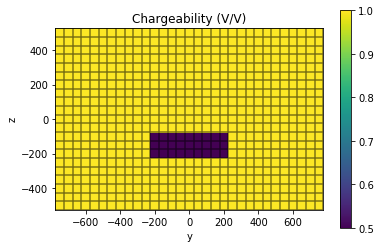

In [4]:
out = mesh.plotSlice(c, grid=True, normal='X')
plt.colorbar(out[0])
plt.title("Chargeability (V/V)")
plt.gca().set_aspect(1)

# Step3: Generate survey and run simulation

In [5]:
x = np.linspace(-400, 400, 21)
y = np.linspace(-400, 400, 21)
rx_locations = Utils.ndgrid(x, y, np.r_[0.])
src_locations = np.array(
    [[-300, 0, 0],[300, 0, 0]]
)

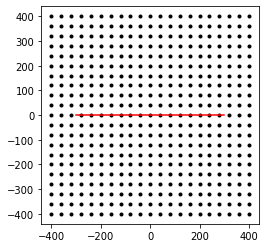

In [6]:
plt.plot(rx_locations[:,0], rx_locations[:,1], 'k.')
plt.plot(src_locations[:,0], src_locations[:,1], 'r-')
plt.gca().set_aspect(1)

In [7]:
times = np.logspace(-3, -2, 11)

In [8]:
rx = Point_e(rx_locations, times, orientation='x')
src = EM.TDEM.Src.LineCurrent(
    [rx], loc=src_locations,waveform=EM.TDEM.Src.StepOffWaveform(),
)

In [10]:
survey = Survey([src])
prb_em = Problem3D_e(mesh, sigmaInf=sigma, eta=eta, tau=tau, c=c)
# prb_em = Problem3D_e(mesh, sigma=sigma)
prb_em.verbose = True
prb_em.timeSteps = [(1e-3, 10)]
prb_em.Solver = Pardiso
prb_em.pair(survey)
data = survey.dpred([])

/Users/sgkang/Projects/simpeg/SimPEG/Props.py:400: UserWarning: Cannot add model as there are no active mappings, choose from: ['cMap', 'etaMap', 'rhoMap', 'sigmaInfMap', 'sigmaMap', 'tauMap']
  "', '".join(self._all_map_names)


Calculating Initial fields
Factorize system matrix for DC problem
**************************************************
Calculating fields(m)
**************************************************
Factoring...   (dt = 1.000000e-03)
Done
    Solving...   (tInd = 1)
    Done...
    Solving...   (tInd = 2)
    Done...
    Solving...   (tInd = 3)
    Done...
    Solving...   (tInd = 4)
    Done...
    Solving...   (tInd = 5)
    Done...
    Solving...   (tInd = 6)
    Done...
    Solving...   (tInd = 7)
    Done...
    Solving...   (tInd = 8)
    Done...
    Solving...   (tInd = 9)
    Done...
    Solving...   (tInd = 10)
    Done...
**************************************************
Done calculating fields(m)
**************************************************


(<matplotlib.contour.QuadContourSet at 0x1a27e4f9b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a27ffef60>)

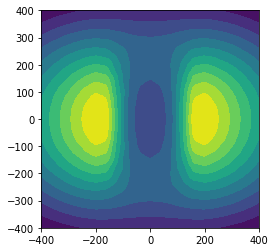

In [11]:
i_time = 10
Utils.plot2Ddata(rx_locations, data.reshape((441, rx.times.size), order='F')[:,i_time])